After tumors have been treated with chemoradiation, there are a lot of molecular / gene expression changes that occur, and it is unclear how the genes that are now interested in are changing in expression. Let's just say that the gene MET is of interest to us, but we are not sure how treatment affects the population of tumor cells that express MET or how it alters MET expression. You could envision a possible scenario in which a patient receives chemotherapy/radiation, which kills off 80% of tumor cells but leaves 20% of tumor cells unfazed. What if these residual cells are super highly expressing in MET? Then, we could theoretically target these cells with a MET inhibitor. The underlying idea we are trying to get at here is whether or not we can target residual disease that does not respond to chemoradiation.

**Specific analyses to perform:**
In order to discover treatment-associated differences, we will need to work with both the untreated/naive dataset and also the treated dataset.

1. Separately, for each of the original X.csv from the naive/untreated data, and also the new X treated.csv file, isolate the tumor cells specifically, because the analysis will only be performed on this cell type for now.
2. Then, isolate specifically the genes that are found in each of two lists attached (fda v1 tumor upregulated and also novel v1 tumor upregulated) for each of the untreated and treated dataset: these lists of genes are compiled from your former analysis (lol though this can be subject to slight change if the Wilcoxon/Mann Whitney above looks drastically different). 
3. We now want to run another set of statistical tests comparing the expression of same gene in the untreated dataset vs the same gene in the treated dataset. And do this for all of the genes. Here are the statistical tests that I think we could do: Wilcoxon, Mann Whitney, and then we can also do the chi squared and fisher, if it's easy for you to integrate those in.

In [31]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact, ranksums

# Get gene/tumor specific datasets

In [9]:
genes_to_keep_fda = pd.read_csv('../data/fda v1 tumor upregulated 111620.csv', header = None)
genes_to_keep_fda = list(genes_to_keep_fda[0])

genes_to_keep_novel = pd.read_csv('../data/novel v1 tumor upregulated 111620.csv', header = None)
genes_to_keep_novel = list(genes_to_keep_novel[0])

### Naive Dataset output

In [4]:
rows_naive = pd.read_csv('../data/rows for X.csv',header = None)
cell_type_naive = list(rows_naive[0])
cell_type_naive = [val.lower() for val in cell_type_naive]

columns_naive = pd.read_csv('../data/columns for X.csv', header = None)
columns_naive = list(columns_naive[0])

In [6]:
df_naive_fda = pd.read_csv('../data/X.csv',names = columns_naive, usecols = genes_to_keep_fda)
df_naive_fda['cell_type'] = cell_type_naive

df_naive_fda_tumor = df_naive_fda[df_naive_fda['cell_type'] == 'tumor']
df_naive_fda_tumor.to_csv('../data/naive_fda_tumor_v1.csv',index = False)

In [8]:
df_naive_novel = pd.read_csv('../data/X.csv',names = columns_naive, usecols = genes_to_keep_novel)
df_naive_novel['cell_type'] = cell_type_naive
df_naive_novel_tumor = df_naive_novel[df_naive_novel['cell_type'] == 'tumor']
df_naive_novel_tumor.to_csv('../data/naive_novel_tumor_v1.csv',index = False)

### Treated Dataset output

In [10]:
rows_treated = pd.read_csv('../data/treated snRNA cell types list.csv',header = None)
cell_type_treated = list(rows_treated[0])
cell_type_treated = [val.lower() for val in cell_type_treated]

columns_treated = pd.read_csv('../data/treated snRNA gene list.csv', header = None)
columns_treated = list(columns_treated[0])

In [12]:
df_treated_fda = pd.read_csv('../data/X treated.csv',names = columns_treated, usecols = genes_to_keep_fda)
df_treated_fda['cell_type'] = cell_type_treated
df_treated_fda_tumor = df_treated_fda[df_treated_fda['cell_type'] == 'tumor']
df_treated_fda_tumor.to_csv('../data/treated_fda_tumor_v1.csv',index = False)

In [13]:
df_treated_novel = pd.read_csv('../data/X treated.csv',names = columns_treated, usecols = genes_to_keep_novel)
df_treated_novel['cell_type'] = cell_type_treated
df_treated_novel_tumor = df_treated_novel[df_treated_novel['cell_type'] == 'tumor']
df_treated_novel_tumor.to_csv('../data/treated_novel_tumor_v1.csv',index = False)

# Read dataframes

In [23]:
gene_group_name = 'novel'

df_treated = pd.read_csv('../data/treated_{}_tumor_v1.csv'.format(gene_group_name))
df_naive = pd.read_csv('../data/naive_{}_tumor_v1.csv'.format(gene_group_name))

genes_to_keep = pd.read_csv('../data/{} v1 tumor upregulated 111620.csv'.format(gene_group_name), header = None)
genes_to_keep = list(genes_to_keep[0])

In [24]:
gene_list = []
ttest_pvalue_list = []
chisq_pvalue_list = []
fisher_pvalue_list = []
ranksum_pvalue_list = []
more_counts_list = []

for gene in genes_to_keep:
    
    naive_values = df_naive[gene]
    treated_values = df_treated[gene]
    
    _, ttest_pvalue = ttest_ind(naive_values, treated_values, equal_var = False)    
    _,ranksums_pval = ranksums(naive_values,treated_values)
    
    naive_zero_count = np.sum(naive_values ==0) 
    naive_nonzero_count = np.sum(naive_values !=0) 
    
    treated_zero_count = np.sum(treated_values ==0) 
    treated_nonzero_count = np.sum(treated_values !=0) 
    
    contingency = [[naive_zero_count,treated_zero_count],
              [naive_nonzero_count,treated_nonzero_count]]

    if (treated_nonzero_count == 0) and (naive_nonzero_count == 0):
    
        chisq_pvalue = 'n/a - all values are zero'
        fisher_pvalue = 'n/a - all values are zero'

    else:
        _, chisq_pvalue, _,_ = chi2_contingency(contingency)
        _, fisher_pvalue = fisher_exact(contingency)

    if naive_nonzero_count/naive_zero_count > treated_nonzero_count/treated_zero_count:
        more_counts_list.append('naive')
    else:
        more_counts_list.append('treated')
        
    gene_list.append(gene)
    ttest_pvalue_list.append(ttest_pvalue)
    chisq_pvalue_list.append(chisq_pvalue)
    fisher_pvalue_list.append(fisher_pvalue)
    ranksum_pvalue_list.append(ranksums_pval)


df_test_results = pd.DataFrame(
{
    'gene': gene_list,
    'two_sided_ttest_pvalue': ttest_pvalue_list,
    'ranksums_pvalue':ranksum_pvalue_list,
    'chisq_pvalue':chisq_pvalue_list,
    'fisher_pvalue':fisher_pvalue_list,
    'greater_pct_nonzero':more_counts_list
}
)

In [25]:
file_name = 'naive_treated_statistical_analysis_{}.csv'.format(gene_group_name)
df_test_results.to_csv(os.path.join('outputs',file_name))

# Violin Plots

In [52]:
df_treated_fda = pd.read_csv('../data/treated_fda_tumor_v1.csv')
df_naive_fda = pd.read_csv('../data/naive_fda_tumor_v1.csv')

df_treated_fda.drop(['cell_type'],axis = 1, inplace = True)
df_naive_fda.drop(['cell_type'],axis = 1, inplace = True)

df_total.shape

df_treated_fda_melt = pd.melt(df_treated_fda, var_name = 'gene')
df_treated_fda_melt['group'] = 'treated'

df_naive_fda_melt = pd.melt(df_naive_fda, var_name = 'gene')
df_naive_fda_melt['group'] = 'naive'

/Users/PeterC/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


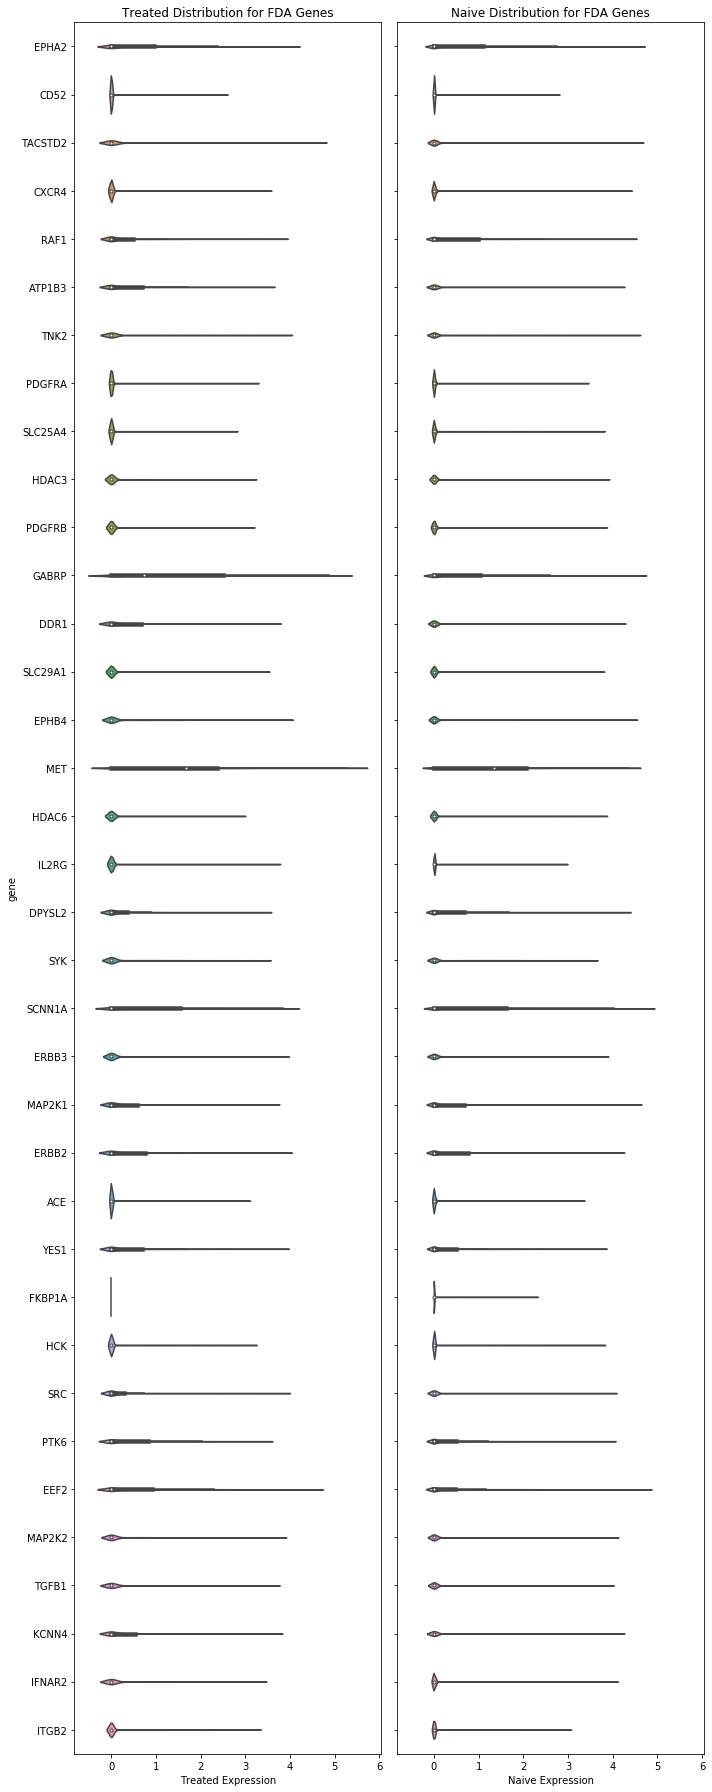

In [59]:
fig, ax =plt.subplots(1,2,sharex=True, sharey=True,figsize = (10,25))
sns.violinplot(x = 'value', y = 'gene', data = df_treated_fda_melt, ax = ax[0])
sns.violinplot(x = 'value', y = 'gene', data = df_naive_fda_melt, ax = ax[1])
ax[0].set_xlabel('Treated Expression')
ax[1].set_ylabel('')
ax[1].set_xlabel('Naive Expression')
ax[0].set_title('Treated Distribution for FDA Genes')
ax[1].set_title('Naive Distribution for FDA Genes')
plt.tight_layout()
fig.show()
fig.savefig('outputs/FDA_gene_violinplot.png')

In [61]:
df_treated_novel = pd.read_csv('../data/treated_novel_tumor_v1.csv')
df_naive_novel = pd.read_csv('../data/naive_novel_tumor_v1.csv')

df_treated_novel.drop(['cell_type'],axis = 1, inplace = True)
df_naive_novel.drop(['cell_type'],axis = 1, inplace = True)

df_total.shape

df_treated_novel_melt = pd.melt(df_treated_novel, var_name = 'gene')
df_treated_novel_melt['group'] = 'treated'

df_naive_novel_melt = pd.melt(df_naive_novel, var_name = 'gene')
df_naive_novel_melt['group'] = 'naive'

/Users/PeterC/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


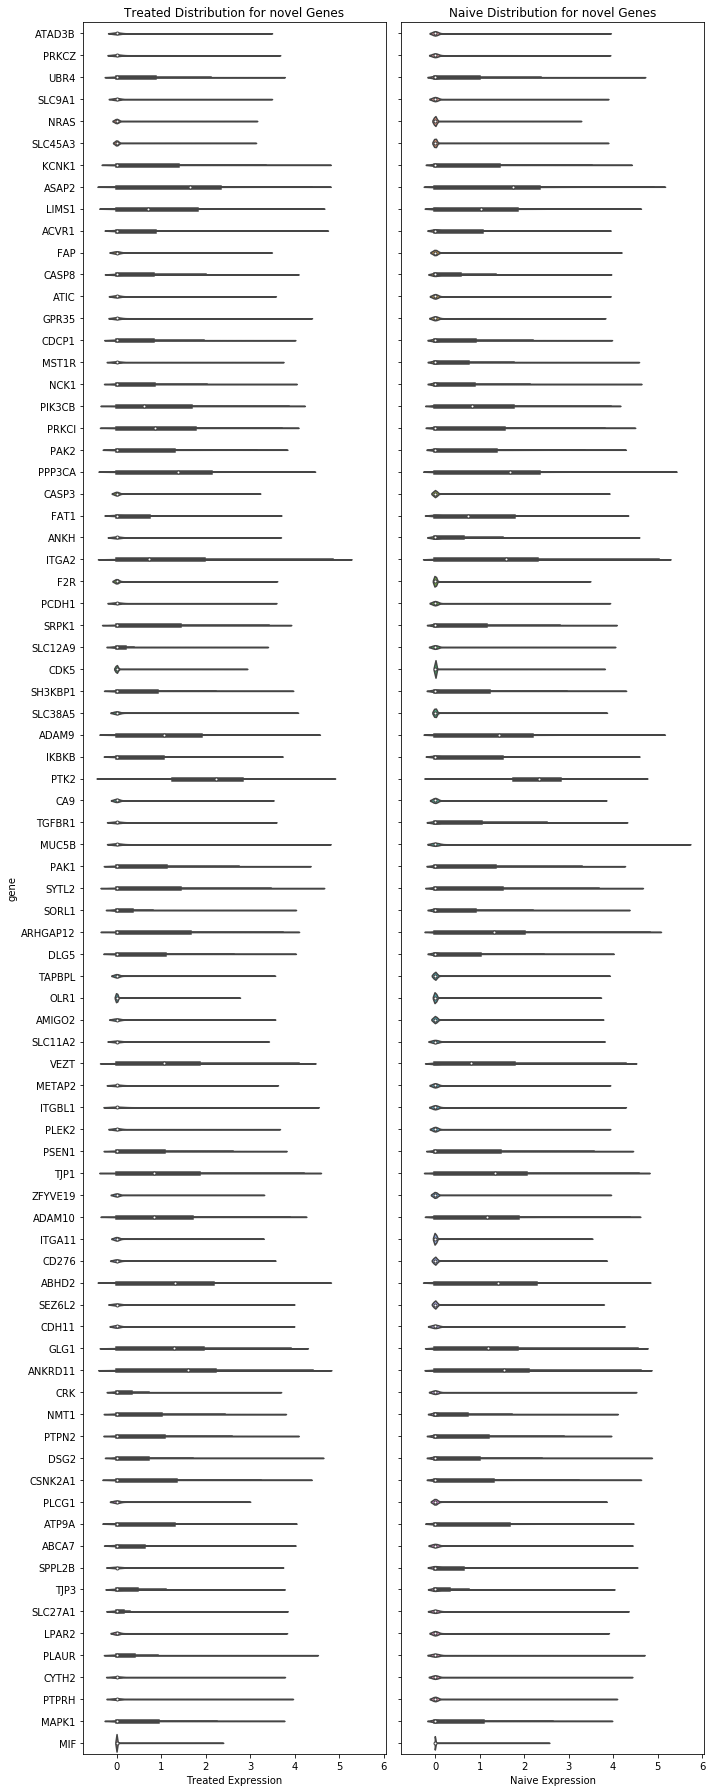

In [62]:
fig, ax =plt.subplots(1,2,sharex=True, sharey=True,figsize = (10,25))
sns.violinplot(x = 'value', y = 'gene', data = df_treated_novel_melt, ax = ax[0])
sns.violinplot(x = 'value', y = 'gene', data = df_naive_novel_melt, ax = ax[1])
ax[0].set_xlabel('Treated Expression')
ax[1].set_ylabel('')
ax[1].set_xlabel('Naive Expression')
ax[0].set_title('Treated Distribution for novel Genes')
ax[1].set_title('Naive Distribution for novel Genes')
plt.tight_layout()
fig.show()
fig.savefig('outputs/novel_gene_violinplot.png')